# velocity calibration

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy

## data loading

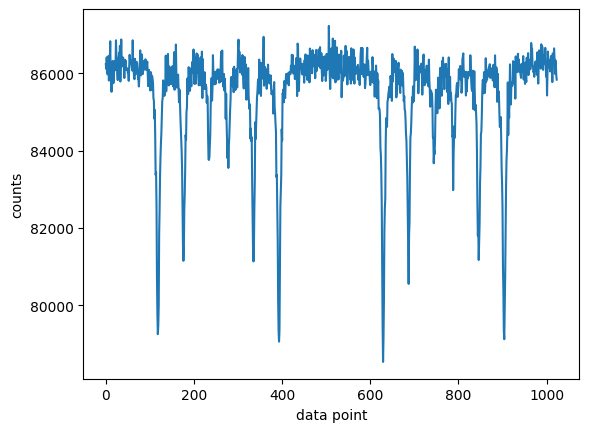

number of data points: 1024


In [2]:
data = np.loadtxt('Fe_calibration.dat')
processed_data = data

plt.plot(data)
plt.xlabel("data point")
plt.ylabel("counts")
plt.show()

print('number of data points: {}'.format(len(data)))

## folding

In [3]:
processed_data, lag = nx.data.AutoFold(processed_data,
                                       flip = 'right',  # determies which part of the spectrum is fliped
                                       factor = 100,   # interpolation on a 100 times finer grid
                                       method = "linear") # or cubic, PChip, Akima

print('lag: {}'.format(lag))

lag: -0.95


##  normalization

In [4]:
processed_data, norm_factor = nx.data.Normalize(processed_data,
                                                method = "baseline", # 'max', 'min'
                                                #left_point=20,
                                                #right_point=250,
                                                #poly_order = 1   # use in case you want to correct a tilted baseline
                                                )

## velocity calibration

In [5]:
# provide approximate velocity of experiment

approximate_veclocity = 9.7

In [6]:
velocities, offset, scaling, vel_theo, int_theo = nx.data.CalibrateChannelsAlphaFe(
                                                    intensity = processed_data,
                                                    velocity = approximate_veclocity,
                                                    thickness = 10e3,
                                                    Bhf = 33.3,
                                                    mode = "constant",
                                                    shift = 0.0)

print("min / max velocity in experiment (mm/s): {} and {}\n".format(min(velocities), max(velocities)))
print("offset (mm/s): {}".format(offset))

min / max velocity in experiment (mm/s): -9.974225771791064 and 10.009581619687763

offset (mm/s): -0.017677923948350015


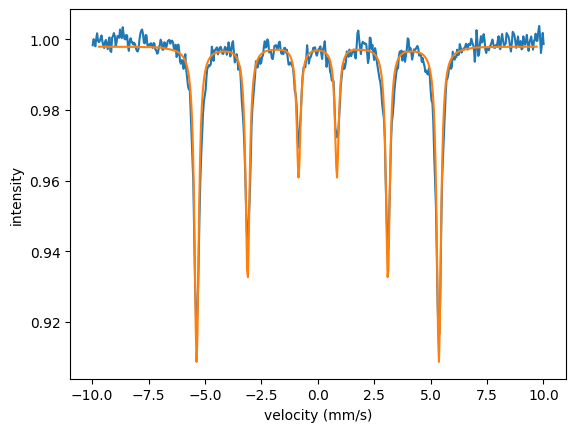

In [7]:
plt.plot(velocities, processed_data)
plt.plot(vel_theo, int_theo)
plt.xlabel("velocity (mm/s)")
plt.ylabel("intensity")
plt.show()

In [8]:
# save a file with the velocity calibration

np.savetxt('velocity_calibration.dat', velocities)

## line fits - resolution and area ratio

In [9]:
# provide number of peaks in spectrum

number_of_peaks = 6

In [10]:
# get a fit of n Lorenzitans

n_peaks, p_indices, p_velocity, p_intensity, p_widths, p_areas, baseline, Lorentzian_fit = nx.data.GetLorentzian(
    velocities,
    processed_data,
    n = number_of_peaks,
    neg = True,
    #baseline = 1.0  # provide a fixed baseline if needed
)

In [11]:
plt.plot(velocities, processed_data)
plt.plot(velocities, Lorentzian_fit)
plt.xlabel("velocity (mm/s)")
plt.ylabel("intensity")
plt.show()

In [12]:
print("peaks at index:")
print(*p_indices)
print("")

print("peaks at velocity (mm/s):")
print(*p_velocity)

peaks at index:
118 176 233 278 335 393

peaks at velocity (mm/s):
-5.363873334543096 -3.1053170994087864 -0.848240491333102 0.855663476406867 3.109047523951859 5.364050615840913


In [13]:
print("line width values (FWHM, mm/s):")
print(*p_widths)
print("")

widths = []
for i in range(len(p_widths)//2):
    widths.append( (p_widths[i] + p_widths[-(i+1)]) / 2)

print("average of lines (FWHM, mm/s):")
print(*widths)

line width values (FWHM, mm/s):
0.31314456141912955 0.30064238590449366 0.29144841427543333 0.3289487357116383 0.29563970713007903 0.2976178359081243

average of lines (FWHM, mm/s):
0.3053811986636269 0.29814104651728635 0.3101985749935358


In [14]:
# resolution from the two inner lines

resolution_value = widths[-1]

print("resolution value (mm/s): {:.3f}\n".format(resolution_value))

resolution_gamma = nx.conversions.VelocityToGamma(resolution_value, nx.lib.moessbauer.Fe57)

print("resolution value (\u0393): {:.3f}\n".format(resolution_gamma))

experiment_resolution = resolution_gamma - 1

print("experimental resolution (resolution value - natural linewidth) (\u0393): {:.3f}".format(experiment_resolution))
print("")
print("use this value as the resolution input when fitting a MoessbauerSpectrum, e.g.")
print("... = MoessbauerSpectrum(..., resolution = experiment_resolution, ...)")

resolution value (mm/s): 0.310

resolution value (Γ): 3.197

experimental resolution (resolution value - natural linewidth) (Γ): 2.197

use this value as the resolution input when fitting a MoessbauerSpectrum, e.g.
... = MoessbauerSpectrum(..., resolution = experiment_resolution, ...)


In [15]:
areas, area_ratio = nx.data.GetAreas(velocities,
                                     processed_data,
                                     n = number_of_peaks,
                                     neg = True)

norm_ar = np.array(area_ratio) / np.min(area_ratio)

print("area ratios of total area:")
print(*area_ratio)

print("")
print("normalized area ratios (to 3rd line):")
print(*norm_ar)
print("")

A23 = areas[1]/areas[2]

print("A23: {}".format(A23))

area ratios of total area:
0.49618117547463003 0.3357144614104132 0.16810436311495672

normalized area ratios (to 3rd line):
2.9516258012608563 1.9970597739978813 1.0

A23: 1.9970597739978813
